# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [6]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)



# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))


time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2020,2,1,0,0,0),
                                    '$lt': datetime.datetime(2020,5,10,0,0,0)},
            'retweeted_id': None
            })
        ))



In [7]:
import json
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
    
filepath = '/home/lisa/Darmstadt/Master Arbeit/05_Data/Scrapy/Twitter_user/Twitter_user/spiders/'
parteien = ['Union', 'SPD', 'Gruene', 'Linke', 'FDP', 'AFD']
parteien_list= {}

users = time_sample_df.user_screen_name

for partei in parteien:
    with open(filepath + partei + '_twitter_Names.json', newline='\n') as json_file:
        Screennames = json.load(json_file)
        parteien_list[str(partei)] = Screennames
        

#for name in set(user_df.screen_name):  #set statt list, wir brauchen jeden User nur einmal
for user in set(users):
    for partei in parteien_list:
        if user in parteien_list[partei]:
            for i in time_sample_df[time_sample_df.user_screen_name == user].index:
                time_sample_df.loc[i, 'Partei'] = partei

#         else:
#             emo_df.at[word, emo] = 0

time_sample_df.head(2)

_id                      created_at  \
0  5e954d137973ce357347fb37  Mon Apr 13 09:42:38 +0000 2020   
1  5e954d137973ce357347fb38  Mon Apr 13 09:32:45 +0000 2020   

  created_at_datetime  \
0 2020-04-13 09:42:38   
1 2020-04-13 09:32:45   

                                                                                                                                                                                                                                                                                               full_text  \
0  Kein Mensch braucht #umfaller/ #fdp weder in der Politik, noch in den Medien... 🙄 https://t.co/qjmEYF73jv                                                                                                                                                                                               
1  Ganz einfach:\nWeil es (zumal auf Dauer!) niemals ein „datenschutzgerechtes Tool“ geben und das ein weiterer großer Schritt Richtung Überwachungsstaat sein wird!\nIch wünsche mir dringend etwas mehr Problembewusstsein und kritische Distanz beim Datenschutzbeauftragten! https://t.co/Rx0cAhIc97   

                    id  is_quote_status lang  retweet_count  \
0  1249634086966132742  True             de   9               
1  1249631600658337793  True             de   23              

                  user_created_at  \
0  Fri Mar 25 13:46:18 +0000 2016   
1  Fri Mar 25 13:46:18 +0000 2016   

                                                                                                                                                  user_description  \
0  *Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎   
1  *Herten, seit 1996 in Gera. MdB seit 10/2017 (vorh. MdL Thüringen ab 10/2014), Vors. Rechtsausschuß bis 13.11.2019 (abgesetzt v. d. Altparteien) Hier: Privat!😎   

   user_followers_count  user_friends_count             user_id  \
0  9341                  676                 713361366858481664   
1  9341                  676                 713361366858481664   

         user_location             user_name user_screen_name Partei  
0  Mal hier, mal da...  🇩🇪Stephan Brandner🇩🇪  StBrandner       AFD    
1  Mal hier, mal da...  🇩🇪Stephan Brandner🇩🇪  StBrandner       AFD

In [9]:
time_sample_df.groupby('Partei').size()
#time_sample_df[time_sample_df.Partei.isnull()].user_screen_name

Partei
AFD       4049 
FDP       12937
Gruene    9980 
Linke     10207
SPD       13575
Union     9924 
dtype: int64

#### Create new Column date_time - erledigt in Datenbank

created_at is saved in Mongodb as string and needs to be converted to a datetime format

https://www.programiz.com/python-programming/datetime/strptime

In [ ]:
# from datetime import datetime

# created_at_datetime = []
# for date in sample_df.created_at:
#     date_string = date
#     date_object = datetime.strptime(date_string, "%a %b %d %H:%M:%S +0000 %Y")
#     created_at_datetime.append(date_object)
    
# sample_df["date_time"] = created_at_datetime
# #sample_df.head()

#### Remove Retweets - erledig bei laden in Notebook
Zu erkennen sind Retweets am "RT" vor dem Text bzw. an der Spalte "retweeted_status"

In [ ]:
# sample_text = sample_df[["created_at_datetime", "full_text", 'retweeted_status']]
# text_df = pd.DataFrame(sample_text)
# text_nRT = sample_text[pd.isnull(sample_text['retweeted_status'])]

### Text Cleaning

In [10]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


sample_df=time_sample_df
# Remove punctuation
sample_df['full_text_processed'] = sample_df['full_text'].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('http.*', '', x))

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
sample_df['full_text_processed'].head(200)

0      kein mensch braucht umfaller/ fdp weder in der politik noch in den medien                                                                                                                                                                                             
1      ganz einfachweil es zumal auf dauer niemals ein datenschutzgerechtes tool geben und das ein weiterer großer schritt richtung überwachungsstaat sein wirdich wünsche mir dringend etwas mehr problembewusstsein und kritische distanz beim datenschutzbeauftragten     
2      fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt                                                                                                                                                                                            
3      zeitonline_pol fordern wir schon lange endlich bewegen sich auch die altparteien afdwirkt                                                                                              

#### Durchsuche nach Tweets und sortiere aus

In [11]:
# Print words that match certain words:
#sample_df['full_text_processed'][sample_df['full_text_processed'].str.match(r'.*al.*')==True]

# Remove Tweets that match certain words:
sample_df = sample_df[~sample_df.full_text_processed.str.contains("fröhlicher gruss")]
#time_sample_df.groupby('Partei').size()
#sample_df.groupby('Partei').size()

#### Stopwords

In [12]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb', 'cducsubt', 'spdbt', 'fdpbt', 'sdpde']
for word in mehr_sw:
    stop_words.append(word)
    


#### Binning 
Diskretisierung von date_time

In [16]:
# Sortieren nach Datum/Zeit
sample_df = sample_df.sort_values(by = ['created_at_datetime'])

#### Verschiedene Binning Ansätze - aus verschiedenen Gründen nicht verwendet
* Bins mit vorgegebenen Breiten (Y, M, ...) -> Labels können nicht mitgenommen werden
* Binning mit value_count -> Direkte Ausgabe der Anzahl pro Bin
* Binning mit groupby -> Ausgabe der Indices

In [ ]:
# cut_bins = pd.interval_range(start=pd.Timestamp('2020-02-01'), periods=9, freq='M')
# cut_labels = [i for i in range(2009,2021)]
# pd.cut(text_nRT['created_at_datetime'], bins=cut_bins, labels=cut_labels)


# text_nRT['created_at_datetime'].value_counts(bins=9, sort=False)

# bins = text_nRT.groupby(pd.cut(text_nRT['created_at_datetime'], bins=9, labels=list(range(1,10))))
# for b in bins.indices:
#     print(b)

#### Unterteilung in Bins und erstellen eines Dictionarys für Zeiträume

In [17]:
sample_df['bins'] = pd.cut(sample_df['created_at_datetime'], bins=15, labels=list(range(1,16)))

labels=list(range(1,16))
weeks = {}
    
for i in labels:
    weeks['week_'+str(i)] = sample_df[sample_df['bins'] == i]    
# Unsaubere Variante - jeweils Variable erstellen:
# globals()['week_'+str(i)] = text_nRT[text_nRT['bins'] == i]

bin_sum_per_week = {}

for label in range(1,16): 
    df = sample_df[sample_df['bins'] == label]
    head = list(df.created_at_datetime.head(1))[0]
    tail = list(df.created_at_datetime.tail(1))[0]
    #print(head.to_datetime)
    #print(type(head))
    bin_sum_per_week[label] = {}
    bin_sum_per_week[label]['Von'] = head
    bin_sum_per_week[label]['Bis'] = tail
bin_sum_per_week


{1: {'Bis': Timestamp('2020-02-07 14:29:18'),
  'Von': Timestamp('2020-02-01 00:05:57')},
 2: {'Bis': Timestamp('2020-02-14 01:19:34'),
  'Von': Timestamp('2020-02-07 14:31:27')},
 3: {'Bis': Timestamp('2020-02-20 19:14:25'),
  'Von': Timestamp('2020-02-14 05:40:57')},
 4: {'Bis': Timestamp('2020-02-27 09:37:22'),
  'Von': Timestamp('2020-02-20 19:16:16')},
 5: {'Bis': Timestamp('2020-03-04 23:45:48'),
  'Von': Timestamp('2020-02-27 09:43:58')},
 6: {'Bis': Timestamp('2020-03-11 14:25:36'),
  'Von': Timestamp('2020-03-05 04:12:03')},
 7: {'Bis': Timestamp('2020-03-18 01:11:41'),
  'Von': Timestamp('2020-03-11 14:27:10')},
 8: {'Bis': Timestamp('2020-03-24 19:11:59'),
  'Von': Timestamp('2020-03-18 04:54:27')},
 9: {'Bis': Timestamp('2020-03-31 09:34:28'),
  'Von': Timestamp('2020-03-24 19:15:39')},
 10: {'Bis': Timestamp('2020-04-06 23:18:00'),
  'Von': Timestamp('2020-03-31 09:36:57')},
 11: {'Bis': Timestamp('2020-04-13 14:20:23'),
  'Von': Timestamp('2020-04-07 04:34:36')},
 12: {'B

### Erstellen eines Dictionary für Parteizugehörikgeit

In [119]:
partei_dic = {}

for partei in parteien:
    partei_dic['tweets_'+ partei] = sample_df[sample_df['Partei'] == partei]  

### Wordcloud Basic

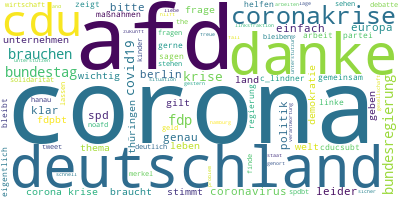

In [11]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(sample_df['full_text_processed'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#fig, axs = plt.subplots(1,2)

#df['korisnika'].plot(ax=axs[0])
#df['osiguranika'].plot(ax=axs[1])

### Wordcloud zu bestimmtem Zeitunkt

(-0.5, 399.5, 199.5, -0.5)

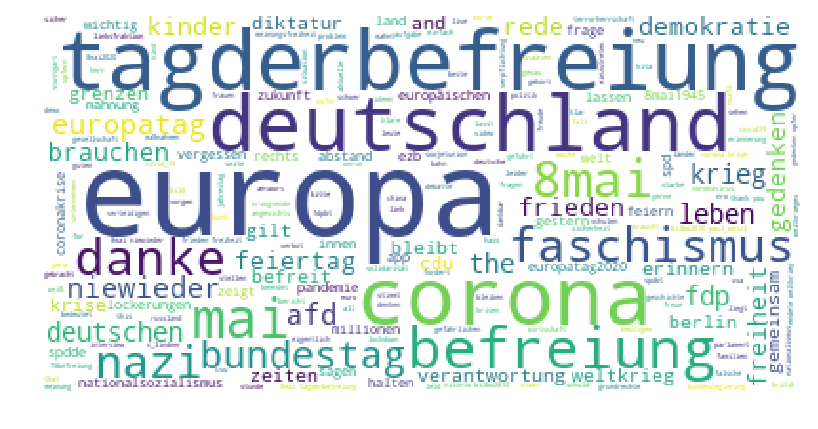

In [112]:
# Import the wordcloud library
from wordcloud import WordCloud

sample_df_date = sample_df[sample_df.created_at_datetime >= datetime.datetime(2020,5,8,0,0,0)]

# Join the different processed titles together.
long_string = ','.join(sample_df_date['full_text_processed'])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=50000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
plt.figure( figsize=(16,7) )
plt.imshow(wordcloud)
plt.axis("off")



### Wordcloud Gegenüberstellung

Text(0.5,1.05,'SPD_Tweets')

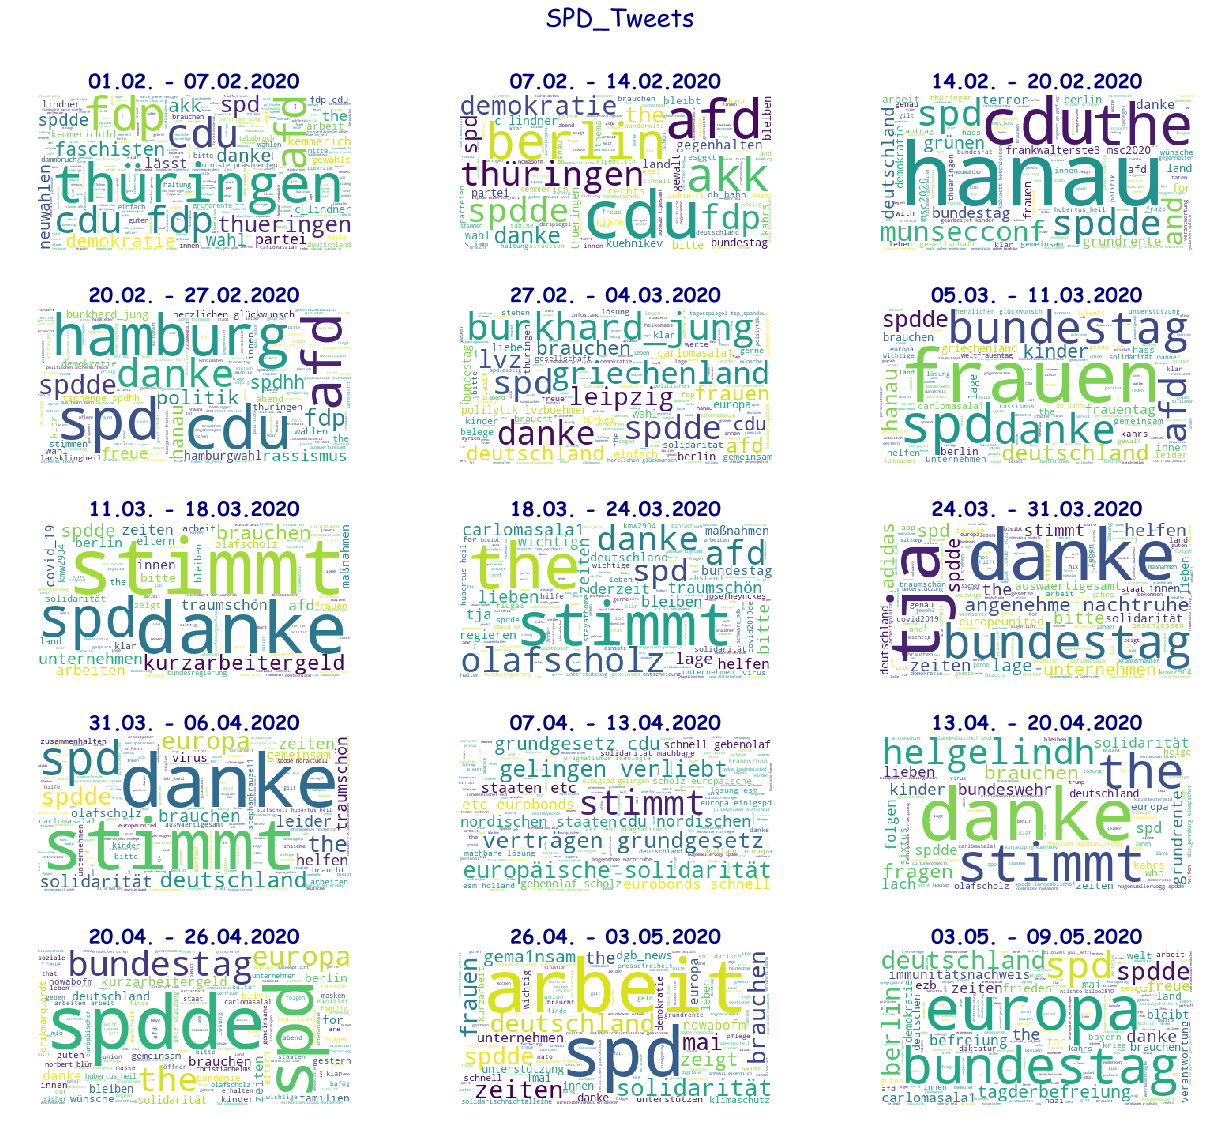

In [183]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud

party = 'SPD'

sample_df_partei = sample_df[sample_df.Partei == party]

date_dic_partei = {}
# for partei in parteien:
#     week_dic_partei['tweets_'+ partei] = date_dic_partei[sample_df['Partei'] == partei]  
    
for week in weeks:
    #date_dic_partei[week + '_' + 'AFD'] = weeks[week].loc("Partei" == 'AFD')
    date_dic_partei[week + '_' + party] = weeks[week].loc[weeks[week].Partei == party]
    #print(weeks[week].loc[weeks[week].Partei == "AFD"])



def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (18, 15))

for i, n in zip(date_dic_partei, range(1,16)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
 

    ax = fig.add_subplot(5,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    sample_df_week=date_dic_partei[i]
    long_string = ','.join(sample_df_week['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')

fig.suptitle(party + '_Tweets', fontsize=25, color='navy', y=1.05)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1.05,'Tweets 8. Mai ohne Corona')

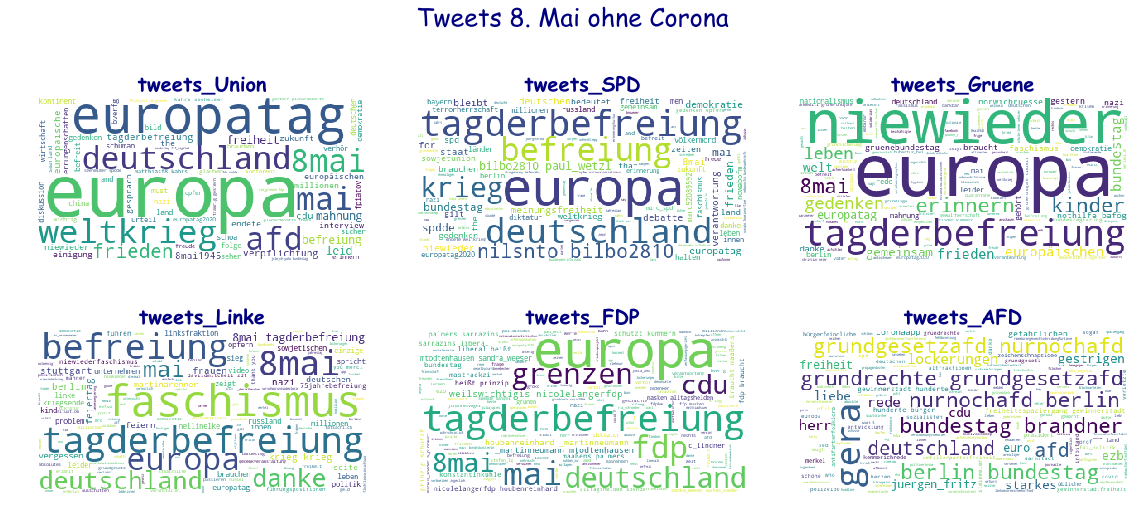

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud


sample_df_date = sample_df[sample_df.created_at_datetime >= datetime.datetime(2020,5,8,0,0,0)]

partei_dic_date = {}
for partei in parteien:
    partei_dic_date['tweets_'+ partei] = sample_df_date[sample_df['Partei'] == partei]  


def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (16, 16))
#fig.subplots_adjust(top=0.8)

for partei, n in zip(partei_dic_date, range(1,7)):
    title = str(partei)
    
    ax = fig.add_subplot(5,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    sample_df_partei=partei_dic_date[partei]
    long_string = ','.join(sample_df_partei['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')
fig.suptitle('Tweets 8. Mai ohne Corona', fontsize=25, color='navy', y=1.05)

### Barplot Basic

In [ ]:
# # Load the library with the CountVectorizer method
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_style('whitegrid')
# %matplotlib inline

# # Helper function
# def plot_10_most_common_words(count_data, count_vectorizer):
#     import matplotlib.pyplot as plt
#     words = count_vectorizer.get_feature_names()
#     total_counts = np.zeros(len(words))
#     for t in count_data:
#         total_counts+=t.toarray()[0]
    
#     count_dict = (zip(words, total_counts))
#     count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
#     words = [w[0] for w in count_dict]
#     counts = [w[1] for w in count_dict]
#     x_pos = np.arange(len(words)) 
    
#     plt.figure(2, figsize=(15, 15/1.6180))
#     plt.subplot(title='10 most common words')
#     sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
#     sns.barplot(x_pos, counts, palette='husl')
#     plt.xticks(x_pos, words, rotation=90) 
#     plt.xlabel('words')
#     plt.ylabel('counts')
#     plt.show()
    
# # Initialise the count vectorizer with the german stop words
# count_vectorizer = CountVectorizer(stop_words=stop_words)

# # Fit and transform the processed titles
# count_data = count_vectorizer.fit_transform(weeks['week_9']['full_text_processed'])
# # Visualise the 10 most common words
# plot_10_most_common_words(count_data, count_vectorizer)


### Barplot Gegenüberstellung

In [ ]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb', 'cducsubt', 'spdbt', 'fdpbt', 'sdpde', 'corona', 'covid19', 'coronakrise', 'coronavirus', 'krise']
for word in mehr_sw:
    stop_words.append(word)
    


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wahr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


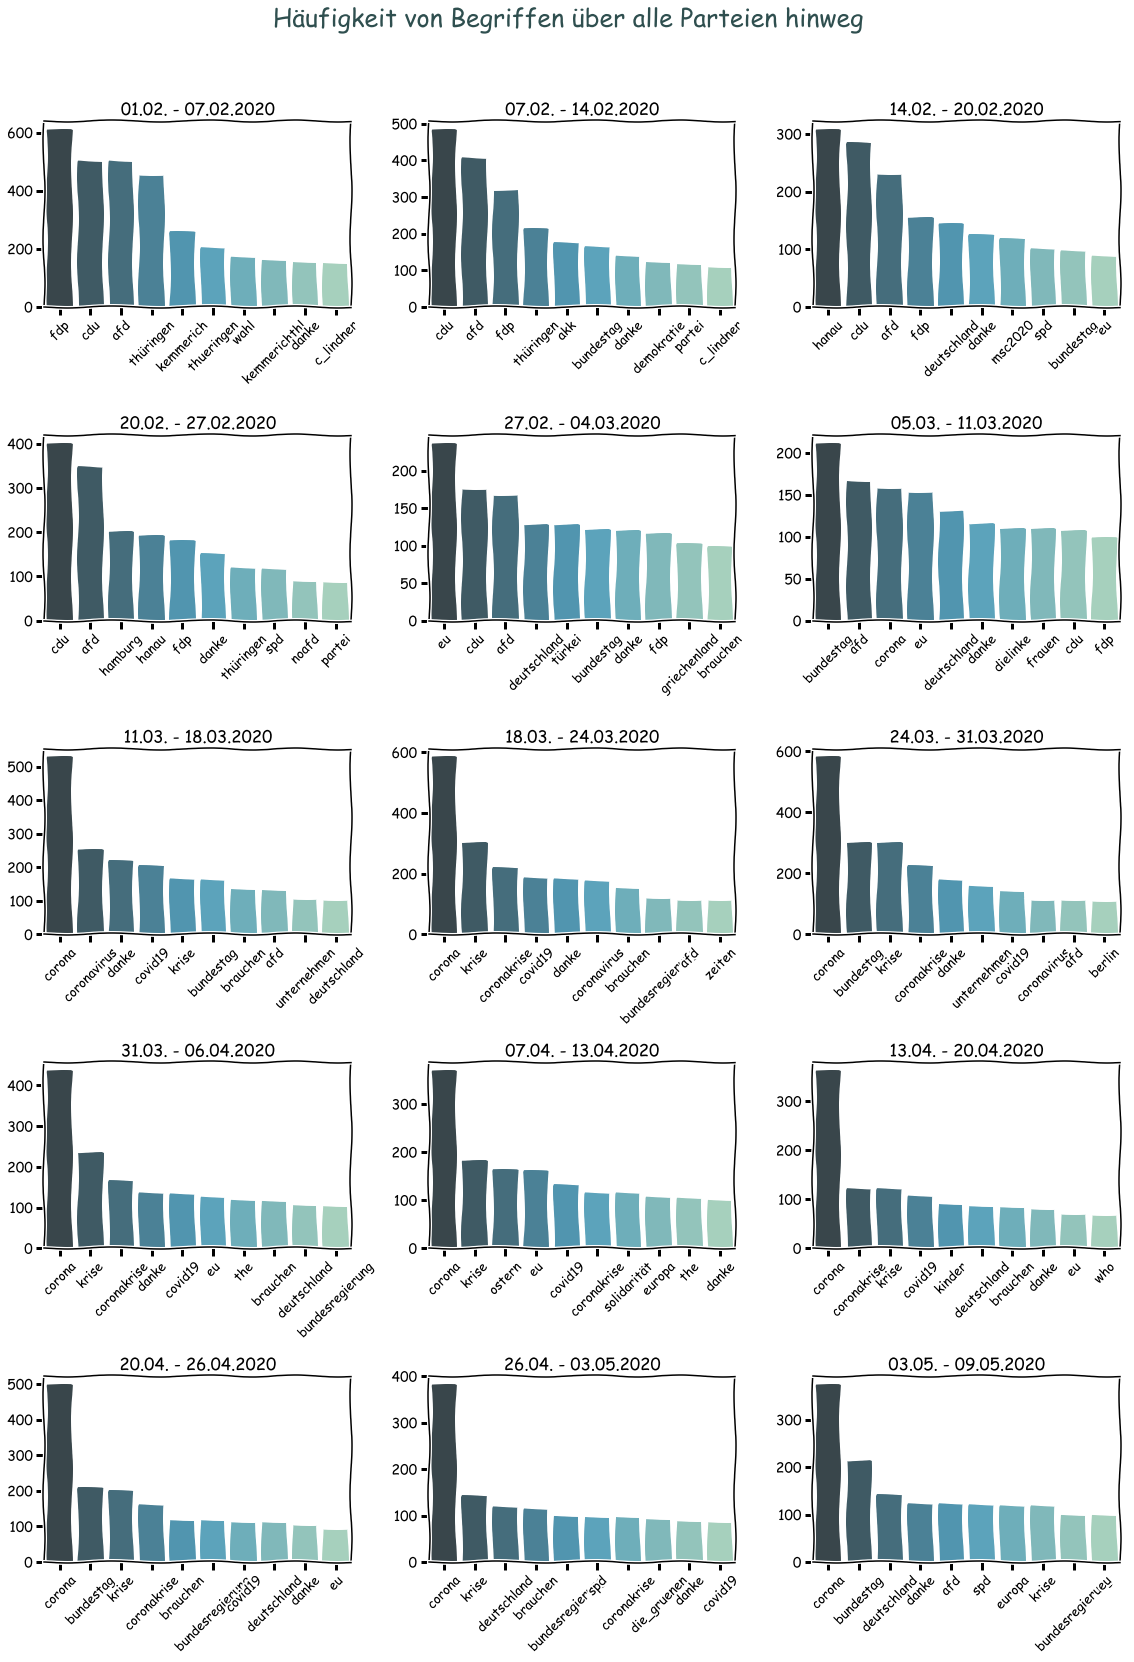

In [189]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer, title):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0] # total_counts = total_counts + t.toarray
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    
    with plt.xkcd():
        ax = fig.add_subplot(5,3,n, title =  title)
        fig.tight_layout()
        ax = sns.barplot(x_pos, counts, palette="GnBu_d")
        ax.set_xticklabels(words, rotation = 45, fontsize=13)
        return ax

    
# Initialise the count vectorizer with the german stop words
count_vectorizer = CountVectorizer(stop_words=stop_words)


fig = plt.figure(figsize = (16, 22))
for i, n in zip(weeks, range(1,16)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(weeks[i]['full_text_processed'])
    plot_10_most_common_words(count_data, count_vectorizer, title)
    
fig.suptitle('Häufigkeit von Begriffen über alle Parteien hinweg', fontsize=25, color='darkslategray', y=1.05)
plt.show()


In [190]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
corona bundestag spd cdu glückwunsch coronakrise berlin danke krise leben

Topic #1:
tagderbefreiung corona deutschland 75 8mai befreiung mai europa bundestag faschismus

Topic #2:
corona the c_lindner to afd bundestag fdp berlin and for

Topic #3:
corona bundestag ezb bundesregierung deutschland europa krise spd klar berlin

Topic #4:
danke corona spd eu afd urteil ezb bitte covid19 tw


In [192]:
sample_df.created_at

0        Mon Apr 13 09:42:38 +0000 2020
1        Mon Apr 13 09:32:45 +0000 2020
2        Mon Apr 13 09:15:47 +0000 2020
3        Mon Apr 13 09:15:36 +0000 2020
4        Mon Apr 13 09:11:50 +0000 2020
5        Mon Apr 13 08:14:19 +0000 2020
6        Sat Apr 11 15:29:32 +0000 2020
7        Sat Apr 11 13:17:14 +0000 2020
8        Sat Apr 11 06:24:16 +0000 2020
9        Sat Apr 11 06:19:17 +0000 2020
10       Sat Apr 11 06:10:36 +0000 2020
11       Sat Apr 11 06:08:15 +0000 2020
12       Thu Apr 09 18:23:56 +0000 2020
13       Thu Apr 09 17:00:28 +0000 2020
14       Thu Apr 09 14:23:54 +0000 2020
15       Thu Apr 09 13:18:41 +0000 2020
16       Thu Apr 09 11:34:56 +0000 2020
17       Thu Apr 09 11:29:37 +0000 2020
18       Thu Apr 09 08:18:13 +0000 2020
19       Wed Apr 08 18:28:25 +0000 2020
20       Wed Apr 08 18:27:51 +0000 2020
21       Wed Apr 08 18:23:48 +0000 2020
22       Wed Apr 08 18:23:32 +0000 2020
23       Wed Apr 08 18:13:02 +0000 2020
24       Wed Apr 08 18:12:43 +0000 2020


In [30]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import os
import pyLDAvis
LDAvis_data_filepath = os.path.join('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/ldavis_prepared_'+ str(number_topics) +'.html')

CPU times: user 959 ms, sys: 40.9 ms, total: 1e+03 ms
Wall time: 2.47 s


In [31]:
pyLDAvis.display(LDAvis_prepared)

/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/lib/python3/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


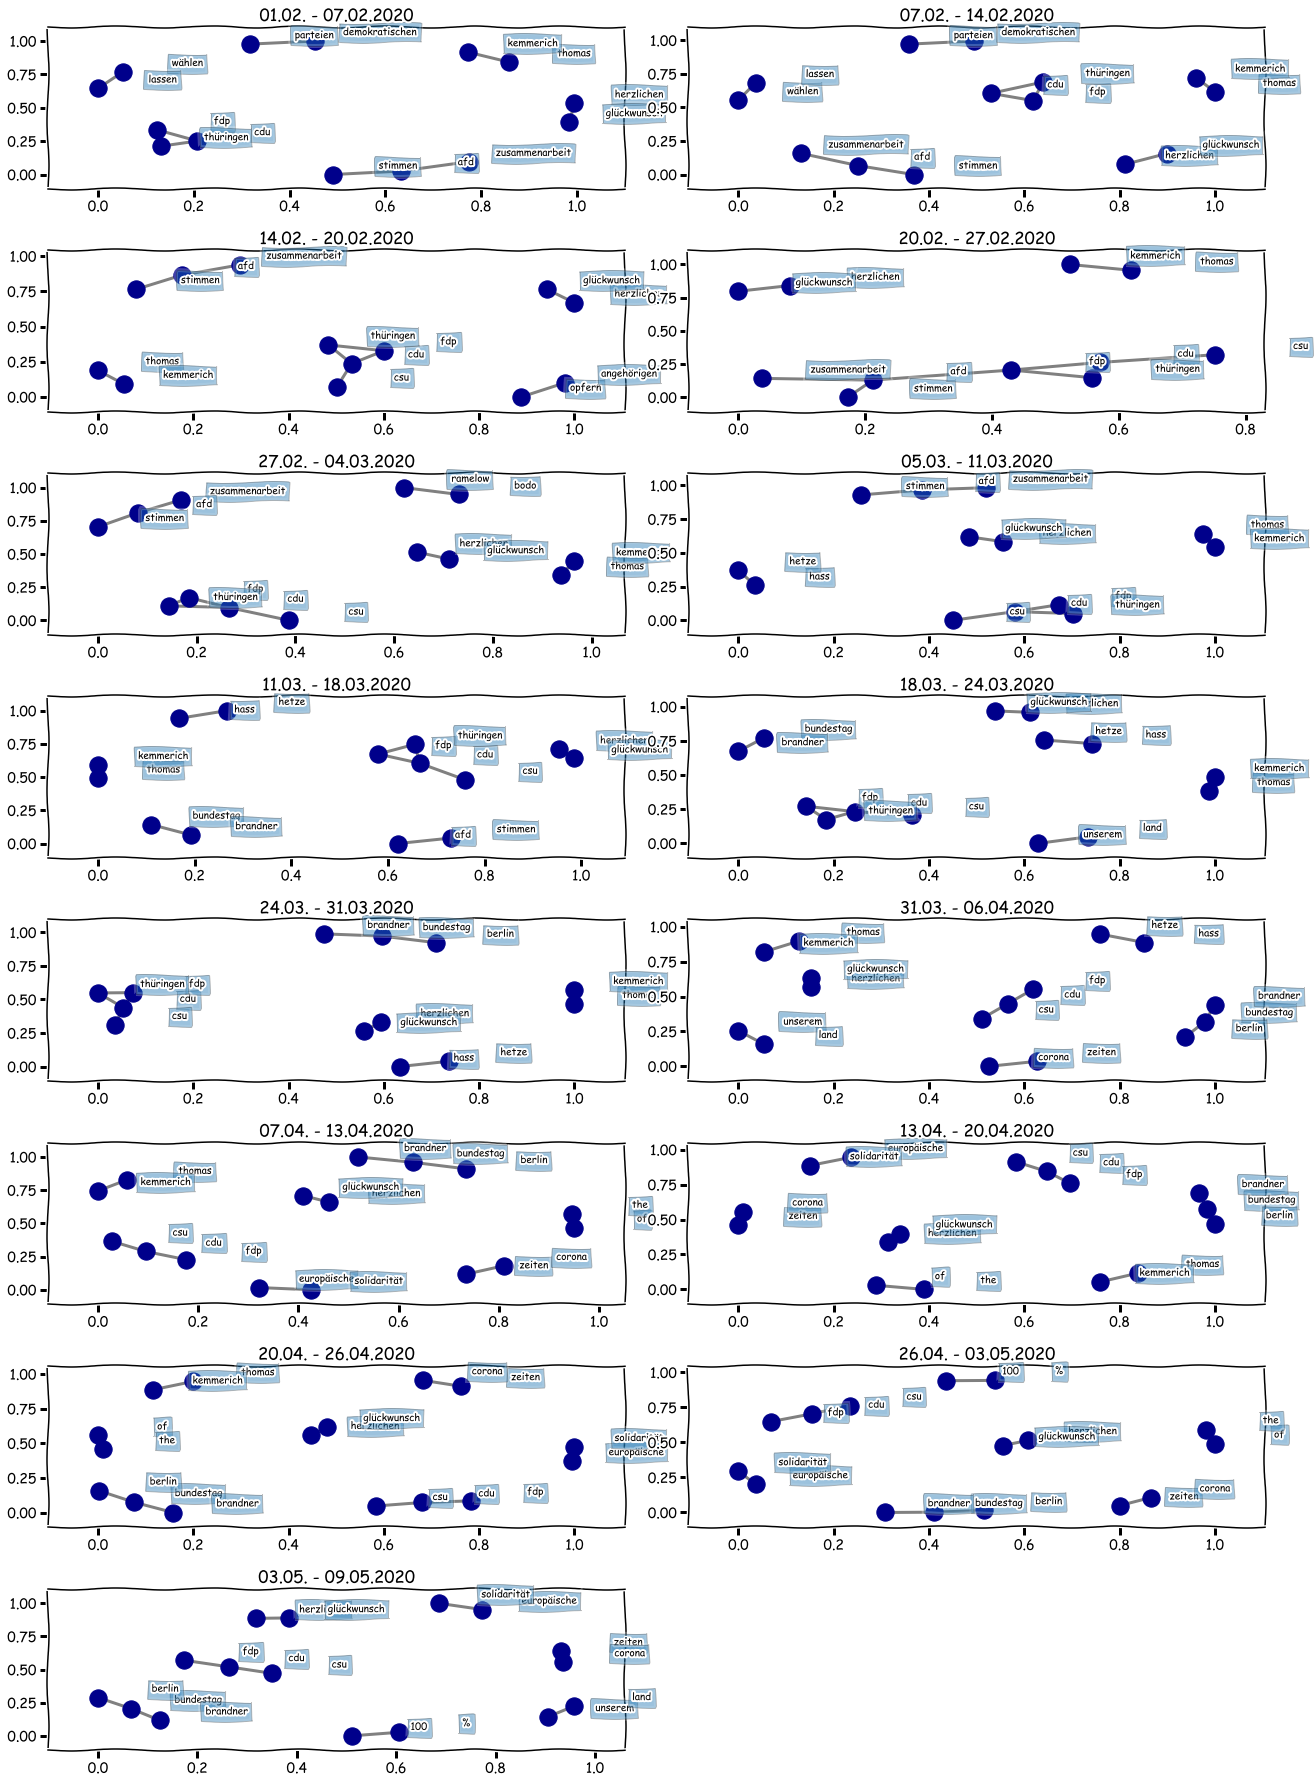

In [220]:
import networkx as nx
import itertools
import collections
import nltk
#nltk.download('punkt')
from nltk import word_tokenize 
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

bigram=[]
   

def make_bigrams_network (df):
    for tweet in df:
        word_data = tweet
        tokens = nltk.word_tokenize(word_data)                            # -> Einzelne Wörter (Tokens)
        tweets_nsw = [word for word in tokens if not word in stop_words]  # -> Ohne StopWords
        terms_bigram = list(nltk.bigrams(tweets_nsw))                     # -> Zweierpärchen (Bigrams) 
        bigram.append(terms_bigram)
    
    terms_bigram = bigram
    # Flatten list of bigrams in clean tweets
    bigrams = list(itertools.chain(*terms_bigram))
    # Create counter of words in clean bigrams
    bigram_counts = collections.Counter(bigrams)
    bigram_counts.most_common(10)
    bigram_df = pd.DataFrame(bigram_counts.most_common(10), columns=['bigram', 'count'])

    # Create dictionary of bigrams and their counts
    d = bigram_df.set_index('bigram').T.to_dict('records')
    
    # Create network plot 
    G = nx.Graph()
    
    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))
        
    ax = fig.add_subplot(8,2,n, title =  title)
    fig.tight_layout()
    pos = nx.spring_layout(G, k=1)
    nx.draw_networkx(G, pos,
                 font_size=14, width=3, edge_color='grey', node_color='darkblue', with_labels = False, ax=ax)
    
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y, s=key, bbox=dict(alpha=0.25), horizontalalignment='center', fontsize=10)
    
        
fig = plt.figure(figsize = (18, 25))

for i, n in zip(weeks, range(1,16)):
    title = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    
    make_bigrams_network(weeks[i]['full_text_processed'])
    

    
# sample_df_date = sample_df[sample_df.created_at_datetime >= datetime.datetime(2020,3,21,0,0,0)]

# partei_dic_date = {}
# for partei in parteien:
#     partei_dic_date['tweets_'+ partei] = sample_df_date[sample_df['Partei'] == partei]  
    
# for partei, n in zip(partei_dic_date, range(1, 7)):
#     title = partei
#     make_bigrams_network(partei_dic_date[partei].full_text_processed)

plt.show()


In [222]:
sample_df.Partei

46557    FDP   
12202    NaN   
60609    NaN   
48187    AFD   
1330     NaN   
1329     NaN   
1328     NaN   
35204    Linke 
21762    SPD   
5990     NaN   
8525     Gruene
5989     NaN   
5988     NaN   
743      AFD   
49419    AFD   
52747    NaN   
5987     NaN   
1076     AFD   
1075     AFD   
46556    FDP   
1074     AFD   
5986     NaN   
31499    Union 
52746    NaN   
5985     NaN   
14808    Linke 
24935    Union 
52745    NaN   
1073     AFD   
38962    NaN   
        ...    
56442    Gruene
42678    NaN   
42677    NaN   
52496    NaN   
52044    FDP   
42676    NaN   
38668    SPD   
52043    FDP   
37010    SPD   
39596    NaN   
39595    NaN   
39593    NaN   
39594    NaN   
52042    FDP   
52041    FDP   
52040    FDP   
52039    FDP   
46088    NaN   
46087    NaN   
52038    FDP   
37009    SPD   
37008    SPD   
37007    SPD   
52037    FDP   
37006    SPD   
37005    SPD   
37004    SPD   
37003    SPD   
37002    SPD   
37001    SPD   
Name: Partei, Length: 59

# Sentiment Analyse - Wörterbuch
## Simple TextBlob Analysis

In [13]:
#import nltk
#nltk.download('punkt')
from textblob_de import TextBlobDE as TextBlob

blob = TextBlob(sample_df.full_text_processed[33504]) 

# print(blob.sentences)
# print(blob.tokens)
# print(blob.tags)
# print(blob.noun_phrases)
print(blob.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)


In [14]:
# https://medium.com/@himanshu_23732/sentiment-analysis-with-textblob-6bc2eb9ec4ab
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None
    
sample_df['Polarity']     = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[0])
sample_df['Subjectivity'] = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[1])
sample_df

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


_id                      created_at  \
0      5e954d137973ce357347fb37  Mon Apr 13 09:42:38 +0000 2020   
1      5e954d137973ce357347fb38  Mon Apr 13 09:32:45 +0000 2020   
2      5e954d137973ce357347fb3a  Mon Apr 13 09:15:47 +0000 2020   
3      5e954d137973ce357347fb3b  Mon Apr 13 09:15:36 +0000 2020   
4      5e954d137973ce357347fb3c  Mon Apr 13 09:11:50 +0000 2020   
5      5e954d137973ce357347fb3e  Mon Apr 13 08:14:19 +0000 2020   
6      5e954d137973ce357347fb43  Sat Apr 11 15:29:32 +0000 2020   
7      5e954d137973ce357347fb45  Sat Apr 11 13:17:14 +0000 2020   
8      5e954d137973ce357347fb4c  Sat Apr 11 06:24:16 +0000 2020   
9      5e954d137973ce357347fb4e  Sat Apr 11 06:19:17 +0000 2020   
10     5e954d137973ce357347fb4f  Sat Apr 11 06:10:36 +0000 2020   
11     5e954d137973ce357347fb50  Sat Apr 11 06:08:15 +0000 2020   
12     5e954d137973ce357347fb53  Thu Apr 09 18:23:56 +0000 2020   
13     5e954d137973ce357347fb56  Thu Apr 09 17:00:28 +0000 2020   
14     5e954d137973ce357347fb58  Thu Apr 09 14:23:54 +0000 2020   
15     5e954d137973ce357347fb5b  Thu Apr 09 13:18:41 +0000 2020   
16     5e954d137973ce357347fb5e  Thu Apr 09 11:34:56 +0000 2020   
17     5e954d137973ce357347fb5f  Thu Apr 09 11:29:37 +0000 2020   
18     5e954d137973ce357347fb65  Thu Apr 09 08:18:13 +0000 2020   
19     5e954d137973ce357347fb69  Wed Apr 08 18:28:25 +0000 2020   
20     5e954d137973ce357347fb6a  Wed Apr 08 18:27:51 +0000 2020   
21     5e954d137973ce357347fb6c  Wed Apr 08 18:23:48 +0000 2020   
22     5e954d137973ce357347fb6d  Wed Apr 08 18:23:32 +0000 2020   
23     5e954d137973ce357347fb6f  Wed Apr 08 18:13:02 +0000 2020   
24     5e954d147973ce357347fb70  Wed Apr 08 18:12:43 +0000 2020   
25     5e954d147973ce357347fb71  Wed Apr 08 18:12:18 +0000 2020   
26     5e954d147973ce357347fb72  Wed Apr 08 18:12:02 +0000 2020   
27     5e954d147973ce357347fb78  Wed Apr 08 15:48:03 +0000 2020   
28     5e954d147973ce357347fb79  Wed Apr 08 15:00:29 +0000 2020   
29     5e954d147973ce357347fb7a  Wed Apr 08 14:59:13 +0000 2020   
...                         ...                             ...   
60759  5eb7a0712c0dd47b6909ce86  Mon Feb 24 10:56:16 +0000 2020   
60760  5eb7a0712c0dd47b6909ce91  Sat Feb 22 10:37:13 +0000 2020   
60761  5eb7a0712c0dd47b6909ce99  Fri Feb 21 07:26:05 +0000 2020   
60762  5eb7a0712c0dd47b6909ce9c  Thu Feb 20 11:19:03 +0000 2020   
60763  5eb7a0712c0dd47b6909cea3  Tue Feb 18 10:06:10 +0000 2020   
60764  5eb7a0712c0dd47b6909cea5  Tue Feb 18 09:52:46 +0000 2020   
60765  5eb7a0712c0dd47b6909cea9  Tue Feb 18 09:33:13 +0000 2020   
60766  5eb7a0712c0dd47b6909ceaa  Tue Feb 18 09:15:00 +0000 2020   
60767  5eb7a0712c0dd47b6909cead  Mon Feb 17 18:06:31 +0000 2020   
60768  5eb7a0712c0dd47b6909ceb5  Mon Feb 17 13:13:45 +0000 2020   
60769  5eb7a0712c0dd47b6909cec0  Mon Feb 17 07:39:32 +0000 2020   
60770  5eb7a0712c0dd47b6909cec1  Sun Feb 16 18:20:58 +0000 2020   
60771  5eb7a0712c0dd47b6909cec2  Sat Feb 15 23:06:15 +0000 2020   
60772  5eb7a0712c0dd47b6909cec6  Sat Feb 15 10:19:48 +0000 2020   
60773  5eb7a0712c0dd47b6909cece  Fri Feb 14 14:40:50 +0000 2020   
60774  5eb7a0712c0dd47b6909ced7  Thu Feb 13 13:11:17 +0000 2020   
60775  5eb7a0712c0dd47b6909cee4  Tue Feb 11 15:12:29 +0000 2020   
60776  5eb7a0712c0dd47b6909ceeb  Mon Feb 10 09:44:58 +0000 2020   
60777  5eb7a0712c0dd47b6909ceed  Mon Feb 10 08:43:05 +0000 2020   
60778  5eb7a0712c0dd47b6909cef3  Sat Feb 08 11:01:04 +0000 2020   
60779  5eb7a0712c0dd47b6909cef4  Sat Feb 08 10:41:24 +0000 2020   
60780  5eb7a0712c0dd47b6909cef9  Sat Feb 08 07:13:54 +0000 2020   
60781  5eb7a0712c0dd47b6909cefb  Fri Feb 07 20:37:47 +0000 2020   
60782  5eb7a0712c0dd47b6909cefc  Fri Feb 07 18:55:59 +0000 2020   
60783  5eb7a0712c0dd47b6909cefd  Fri Feb 07 17:11:21 +0000 2020   
60784  5eb7a0712c0dd47b6909ceff  Fri Feb 07 16:59:04 +0000 2020   
60785  5eb7a0712c0dd47b6909cf0b  Thu Feb 06 21:58:31 +0000 2020   
60786  5eb7a0712c0dd47b6909cf16  Tue Feb 04 12:10:47 +0000 2020   
60787  5

In [207]:
# compute sentiment scores (polarity) and labels
sentiment_scores = sample_df['Polarity']
sentiment_category = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores]


# sentiment statistics per news category
df_weeks = pd.DataFrame([list(sample_df['bins']), list(sample_df['Partei']), list(sentiment_scores), list(sentiment_category)]).T
df_weeks.columns = ['bins', 'partei', 'sentiment_score', 'sentiment_category']
df_weeks['sentiment_score'] = df_weeks.sentiment_score.astype('float')
df_weeks.groupby(by=['partei']).describe()

sentiment_score                                             
                 count      mean       std  min  25%  50%  75%  max
partei                                                             
AFD     4049.0          0.038806  0.523939 -1.0  0.0  0.0  0.0  1.0
FDP     12937.0         0.141739  0.520718 -1.0  0.0  0.0  0.7  1.0
Gruene  9980.0          0.173555  0.526769 -1.0  0.0  0.0  0.7  1.0
Linke   10207.0         0.092384  0.541210 -1.0  0.0  0.0  0.5  1.0
SPD     12769.0         0.200093  0.503615 -1.0  0.0  0.0  0.7  1.0
Union   9924.0          0.206844  0.523831 -1.0  0.0  0.0  0.7  1.0

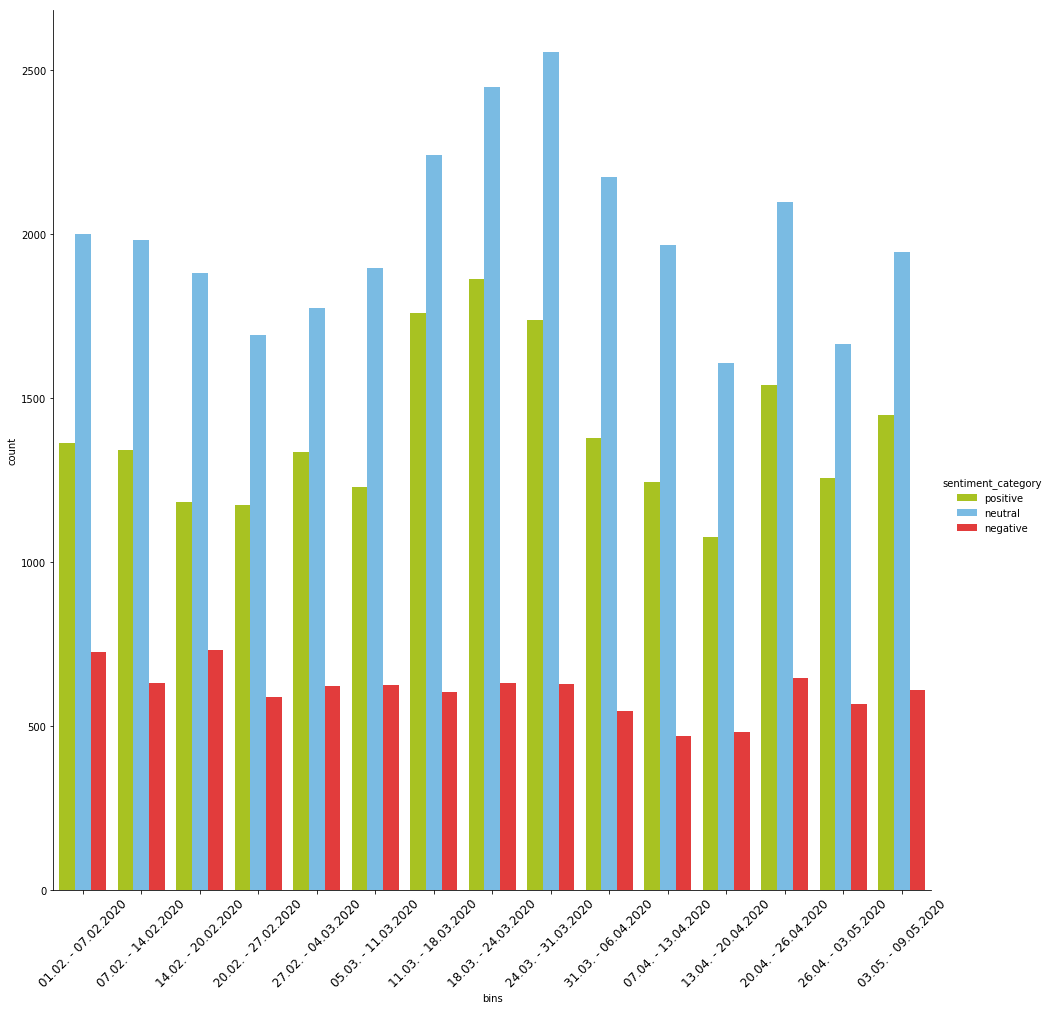

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = []


for i, n in zip(weeks, range(1,16)):
    label = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    labels.append(label)
    
ax = sns.catplot(x="bins", hue="sentiment_category", height=13,
                    data=df_weeks, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
ax.set_xticklabels(labels, rotation = 45, fontsize=12)

#print(labels)

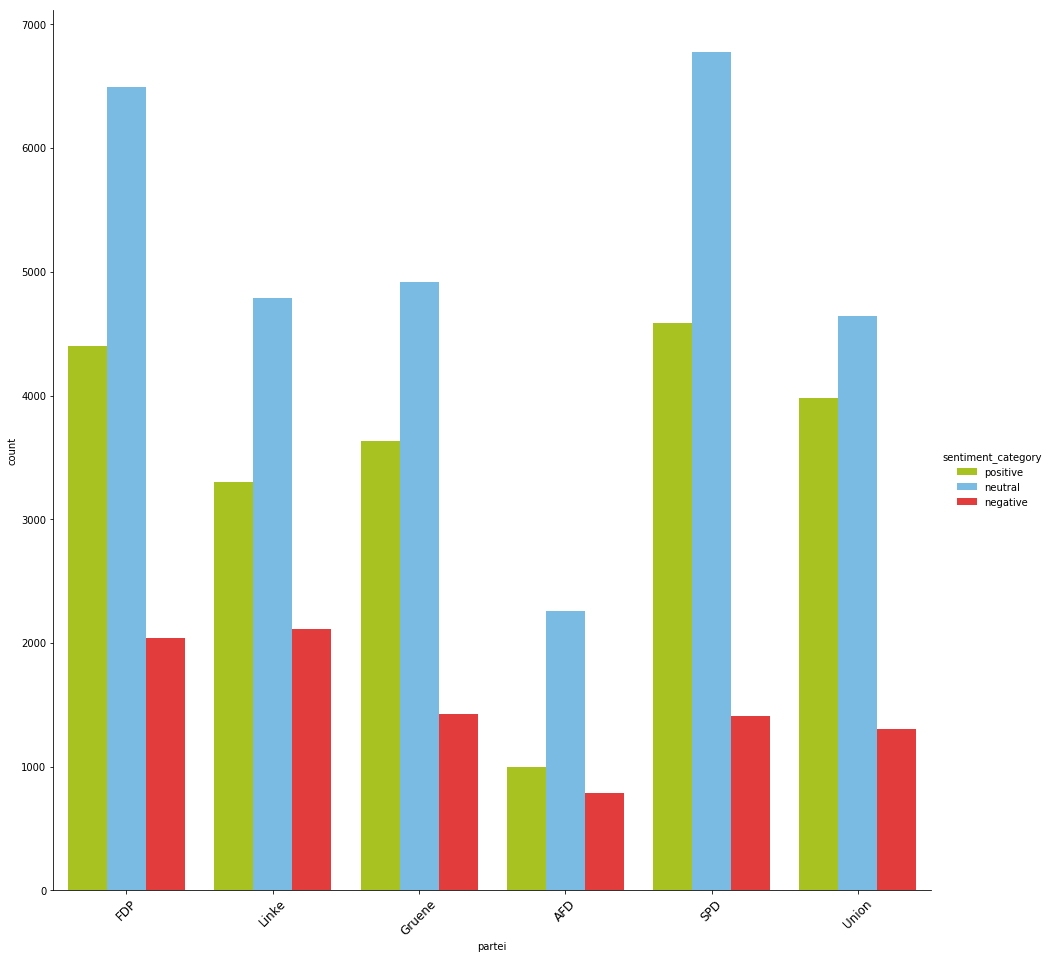

In [202]:
ax = sns.catplot(x="partei", hue="sentiment_category", height=13,
                    data=df_weeks, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})
ax.set_xticklabels(rotation = 45, fontsize=12)

Text(0.5,1.05,'Häufigkeit von von pos, neg und neut Tweets nach Parteien')

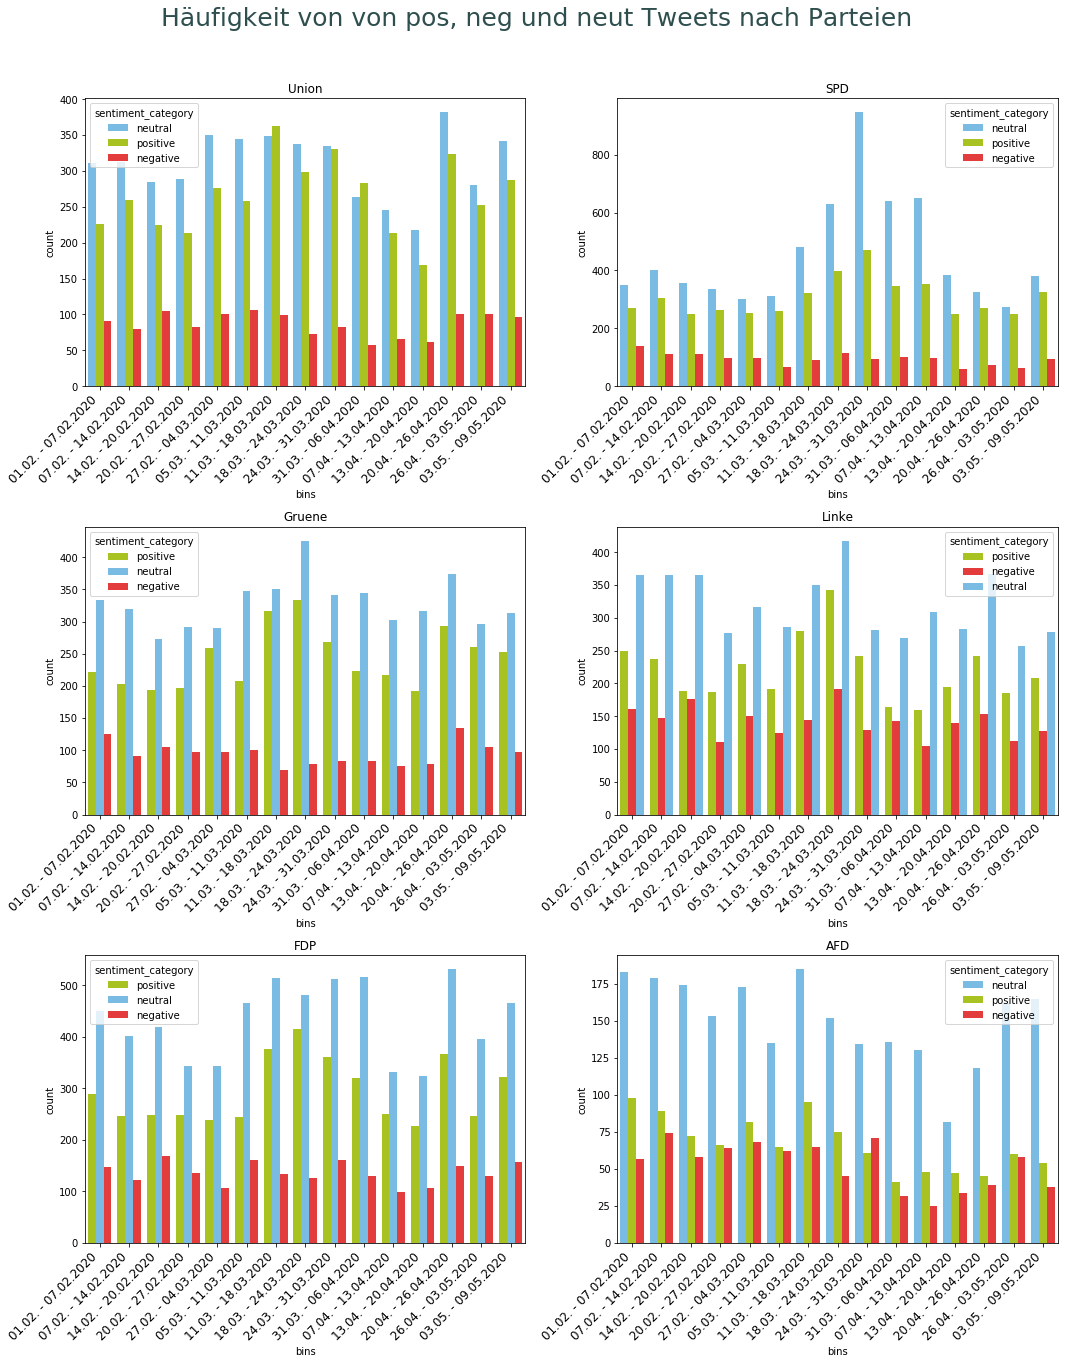

In [233]:
partei_dic_sent = {}
for partei in parteien:
    partei_dic_sent['sentiment_'+ partei] = df_weeks[df_weeks['partei'] == partei]  
    
for i, n in zip(weeks, range(1,16)):
    label = "%s - %s" % (bin_sum_per_week[n]['Von'].strftime('%d.%m.'),
                         bin_sum_per_week[n]['Bis'].strftime('%d.%m.%Y'))
    labels.append(label)

fig = plt.figure(figsize = (15, 18))

for partei, n in zip(parteien, range(1,7)):
    ax = fig.add_subplot(3,2,n, title = partei)
    fig.tight_layout()
    sns.catplot(x="bins", hue="sentiment_category", data=partei_dic_sent['sentiment_'+partei], kind="count", palette={"negative": "#FE2020", "positive": "#BADD07", "neutral": "#68BFF5"}, ax=ax)
    ax.set_xticklabels(labels, rotation = 45, fontsize=12, ha='right')
    plt.close(2)
    
fig.suptitle('Häufigkeit von von pos, neg und neut Tweets nach Parteien', fontsize=25, color='darkslategray', y=1.05)

## Basic Emotions

In [29]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm


import csv
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
######### Erstelle Emotions-Matrix

filepath = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Lexicon_based/german-emotion-dictionary/fundamental/'
emo_df = []
words = []
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
emotion_list= {}
stemmer = SnowballStemmer("german")

for emo in emotion:
    with open(filepath + emo + '.txt', newline='\n') as f:
        reader = csv.reader(f)
        data = [item for sublist in reader for item in sublist] 
        emotion_list[str(emo)] = data
        words.extend(data)
        
words = list(set(words)) # remove Duplicates which come from overlapping EmotionLists
emo_df  = pd.DataFrame(index=words, columns=emotion)

words = []
for word in emo_df.index:
    for emo in emo_df.columns:
        if word in emotion_list[emo]:
            emo_df.at[word, emo] = 1
        else:
            emo_df.at[word, emo] = 0
    words.append(stemmer.stem(word.lower()))
 
emo_df.index= words
emo_df = emo_df.sort_index(ascending=True)
emo_df = pd.DataFrame(emo_df)
emo_df = emo_df.loc[~emo_df.index.duplicated(keep='first')]

emo_df.head()


Ekel Freude Furcht Trauer Ueberraschung Verachtung Wut
aalglatt     0    0      0      0      0             1          0 
aasgei       0    0      0      0      0             1          0 
abbrech      0    0      0      1      0             0          0 
abbruchreif  0    0      0      0      0             1          0 
abbugeln     0    0      0      0      0             1          0

In [ ]:
# print_debug = False
# def debug(string):
#     if print_debug == True:
#         print(string)

# for word in emo_df.index:
#      debug("'%s'" % (word))
#      debug(type(word))
#      #for emo in emotion_list:
#      for emo in emo_df.columns:
#          #print(emo)
#          #print(type(emo))
#          if word in emotion_list[emo]:
#              debug("Word '%s' is of emotion: '%s'" % (word, emo))
#              #print(emo_df[emo][word])
#              #print(emo_df.columns)
#              #print(emo_df.ix[1])
#              emo_df.at[word, emo] = 1
#              debug(emo_df.loc[word])
#              debug("\n")

#          #else:
#          #    emo_df.at[str(emo)][word] = 0

# emo_df[1:12]

In [92]:
#from fuzzywuzzy import fuzz
emo_base_df = sample_df['full_text_processed']
df_emo = pd.DataFrame(0, index=emo_base_df.index, columns=emotion)

for i in emo_base_df.index:
    document = word_tokenize(emo_base_df.loc[i])
    for word in document:
        word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
        emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

#         for w in emo_df.index:
#             fuz = fuzz.ratio(str(w), word)
#             if fuz > 98:
#                 emo_score = emo_df[emo_df.index == w].drop_duplicates(keep = 'first')    

        if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
            for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
                df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet 
                

emo_base_df = pd.concat([emo_base_df, df_emo], axis=1)

emo_base_df.head(20)

full_text_processed  \
46557  raus aber nicht weg zum brexitday ein konvolut der faznet in dem sich ein klassiker versteckt die beschreibung des gurkensandwich von jakob serra y strobel ist so wunderbar und auch cricket spießt liebevoll den britischen lifestyle auf brexit                                                             
12202  kleine rückfrage an trolle im netz die fakes über mein privatleben verbreiten und behaupten ich würde meine ehefrau betrügen nur damit ich alles richtig mache welche ehefrau  ansonsten danke für die ganze kohle die ich mit den strafanzeigen verdiene ich geh jetzt feiern                                 
60609  sehenswert ruhige info zu corona zu gast prof dr christian drosten - leiter des instituts für virologie an der berliner charité - talk aus berlin | rbb                                                                                                                                                        
48187  guten morgen deutschland die briten england hat es geschafft glückwunsch zum brexit                                                                                                                                                                                                                            
1330   so kommentieren die gez-komiker des zdf den brexit                                                                                                                                                                                                                                                             
1329   die spätfolgen des kommunismus in einem bild                                                                                                                                                                                                                                                                   
1328   man braucht in deutschland keine islamische partei gründen diesen job übernehmen die grünen die farbe passt auch vollverschleierung                                                                                                                                                                            
35204  st_klaene linksfraktion für die ersten fragen bin ich zu müde obzwar ich dezidiert antwort geben könnte die letzte ist hingegen höchst interessant und nachdenkenswert                                                                                                                                         
21762  buongiorno aus franken  allen ein entspanntes wochenende                                                                                                                                                                                                                                                       
5990   watchu28020892 wer ist ihr informant und was wollen sie kontrollieren                                                                                                                                                                                                                                          
8525   now that they are gone - where did they go brexit                                                                                                                                                                                                                                                              
5989   babsi0909 watchu28020892 wenn nur einmal getestet wird und nicht wiederholt na klar gibt es falsch negative testungen                                                                                                                                                                                          
5988   getrichguru watchu28020892 definieren sie bitte außer kontrolle das ist nur panikmache was sie da treiben wie stehen sie zur grippe                                                                                                           

In [234]:
#### Add Timestamp
# -> In Grafiken später mit abgebildet

emo_base_df['Partei'] = sample_df['Partei']
emo_base_df['created_at_datetime'] = sample_df['created_at_datetime']
#emo_base_df.head(20)

In [242]:
### Remove empty full_text_processed
# -> Wenn z.B. nur ein Link und emojis gepostet wurden ist nach dem text cleaning die Zelle leer (aber nicht isnull() == true)
# sample_df[sample_df.created_at_datetime == datetime.datetime(2020,2,1,7,26,32)]

emo_base_text = emo_base_df.drop(emo_base_df[emo_base_df['full_text_processed']==''].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']==' '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='  '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='   '].index)
#emo_base_text[emo_base_text['full_text_processed']=='']

In [247]:
emo_party = emo_base_text.groupby('Partei').sum()
emo_party.head()


Ekel  Freude  Furcht  Trauer  Ueberraschung  Verachtung  Wut
Partei                                                              
AFD     83    971     470     485     372            1066        225
FDP     240   3143    1463    2081    1450           2867        665
Gruene  198   3174    1136    1729    1154           1886        522
Linke   249   2847    1580    1807    1082           2945        587
SPD     234   4385    1227    1801    1173           2172        529

In [248]:
#### Relative Werte
# 1.) Teilen durch Wordcount pro Tweet

from nltk import tokenize
from nltk import word_tokenize

emo_base_rel=emo_base_text

emo_base_rel['word_count'] = emo_base_rel['full_text_processed'].apply(tokenize.word_tokenize).apply(len)

for emo in emotion:
    emo_base_rel[emo] = emo_base_rel[emo] / emo_base_rel['word_count']


In [244]:
emo_base_rel.head()

full_text_processed  \
46557  raus aber nicht weg zum brexitday ein konvolut der faznet in dem sich ein klassiker versteckt die beschreibung des gurkensandwich von jakob serra y strobel ist so wunderbar und auch cricket spießt liebevoll den britischen lifestyle auf brexit                                 
12202  kleine rückfrage an trolle im netz die fakes über mein privatleben verbreiten und behaupten ich würde meine ehefrau betrügen nur damit ich alles richtig mache welche ehefrau  ansonsten danke für die ganze kohle die ich mit den strafanzeigen verdiene ich geh jetzt feiern     
60609  sehenswert ruhige info zu corona zu gast prof dr christian drosten - leiter des instituts für virologie an der berliner charité - talk aus berlin | rbb                                                                                                                            
48187  guten morgen deutschland die briten england hat es geschafft glückwunsch zum brexit                                                                                                                                                                                                
1330   so kommentieren die gez-komiker des zdf den brexit                                                                                                                                                                                                                                 

       Ekel    Freude    Furcht    Trauer  Ueberraschung  Verachtung  Wut  \
46557  0.0   0.026316  0.000000  0.000000  0.0            0.000000    0.0   
12202  0.0   0.023256  0.023256  0.023256  0.0            0.069767    0.0   
60609  0.0   0.000000  0.000000  0.000000  0.0            0.000000    0.0   
48187  0.0   0.166667  0.000000  0.000000  0.0            0.000000    0.0   
1330   0.0   0.000000  0.000000  0.000000  0.0            0.000000    0.0   

       Partei created_at_datetime  word_count  
46557  FDP    2020-02-01 00:05:57  38          
12202  Linke  2020-02-01 00:50:09  43          
60609  Gruene 2020-02-01 00:55:07  27          
48187  AFD    2020-02-01 05:03:12  12          
1330   AFD    2020-02-01 05:12:22  8

In [245]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### bringt nicht die richtigen Ergebnisse

emo_party_rel_0 = emo_base_rel.groupby('Partei').sum().apply(lambda x: x/float(x.count()))
emo_party_rel_0.head()

Ekel     Freude     Furcht     Trauer  Ueberraschung  Verachtung  \
Partei                                                                         
AFD     0.742624  10.037953  3.676343   4.480716   4.278938       10.033392    
FDP     1.905514  29.383876  10.153719  16.305081  11.275384      23.553952    
Gruene  1.979839  36.374269  7.727292   13.243920  9.390699       14.056638    
Linke   1.815618  24.090724  9.328171   11.742464  7.878040       20.045505    
SPD     1.944791  56.944141  8.022918   13.500250  10.653714      20.140889    

             Wut    word_count  
Partei                          
AFD     1.913315  12254.666667  
FDP     4.810884  45170.833333  
Gruene  3.653809  34994.166667  
Linke   3.902425  40920.666667  
SPD     3.799807  41250.833333

In [348]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### umständliche aber korrekte Version
emo_party_sum = emo_base_rel.groupby('Partei').sum()
emo_party_count = emo_base_rel.groupby('Partei').count()
emo_party_rel_1 = emo_party_sum/ emo_party_count
emo_party_rel_1

Ekel    Freude    Furcht    Trauer  Ueberraschung  Verachtung  \
Partei                                                                      
AFD     0.001120  0.015140  0.005545  0.006758  0.006454       0.015133     
FDP     0.000888  0.013699  0.004734  0.007601  0.005257       0.010981     
Gruene  0.001204  0.022128  0.004701  0.008057  0.005713       0.008551     
Linke   0.001071  0.014206  0.005501  0.006924  0.004646       0.011820     
SPD     0.000920  0.026941  0.003796  0.006387  0.005040       0.009529     
Union   0.000784  0.019484  0.004013  0.006621  0.005339       0.009342     

             Wut  created_at_datetime  full_text_processed  word_count  
Partei                                                                  
AFD     0.002886 NaN                  NaN                   18.483660   
FDP     0.002243 NaN                  NaN                   21.058664   
Gruene  0.002223 NaN                  NaN                   21.288148   
Linke   0.002301 NaN                  NaN                   24.130123   
SPD     0.001798 NaN                  NaN                   19.514705   
Union   0.001898 NaN                  NaN                   21.950208

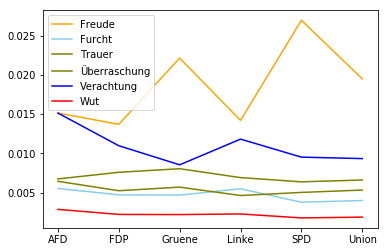

In [323]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# fig = plt.figure(figsize = (15, 18))
   
    
# ax = sns.catplot(x=emo_party_rel_1.index, hue=emo_party_rel_1.columns[1:7], height=13,
#                     data=emo_party_rel_1, kind="bar", 
#                     palette='GnBu_d')
# ax.set_xticklabels(rotation = 45, fontsize=12)
# #fig.suptitle('Häufigkeit von von pos, neg und neut Tweets nach Parteien', fontsize=25, color='darkslategray', y=1.05)

# for emo in emotion:
#     fig, ax = plt.subplots()
#     ax.scatter(emo_base_rel.index,emo_base_rel[emo])

# plt.show()

# for emo in emotion:
#     fig, ax = plt.subplots()
#     ax.scatter(emo_party_rel_1.index,emo_party_rel_1[emo])

# plt.show()

plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[1], data=emo_party_rel_1, color='orange')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[2], data=emo_party_rel_1, color='skyblue')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[3], data=emo_party_rel_1, color='olive')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[4], data=emo_party_rel_1, color='olive',label="Überraschung")
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[5], data=emo_party_rel_1, color='blue')
plt.plot( emo_party_rel_1.index, emo_party_rel_1.columns[6], data=emo_party_rel_1, color='red')
plt.legend()


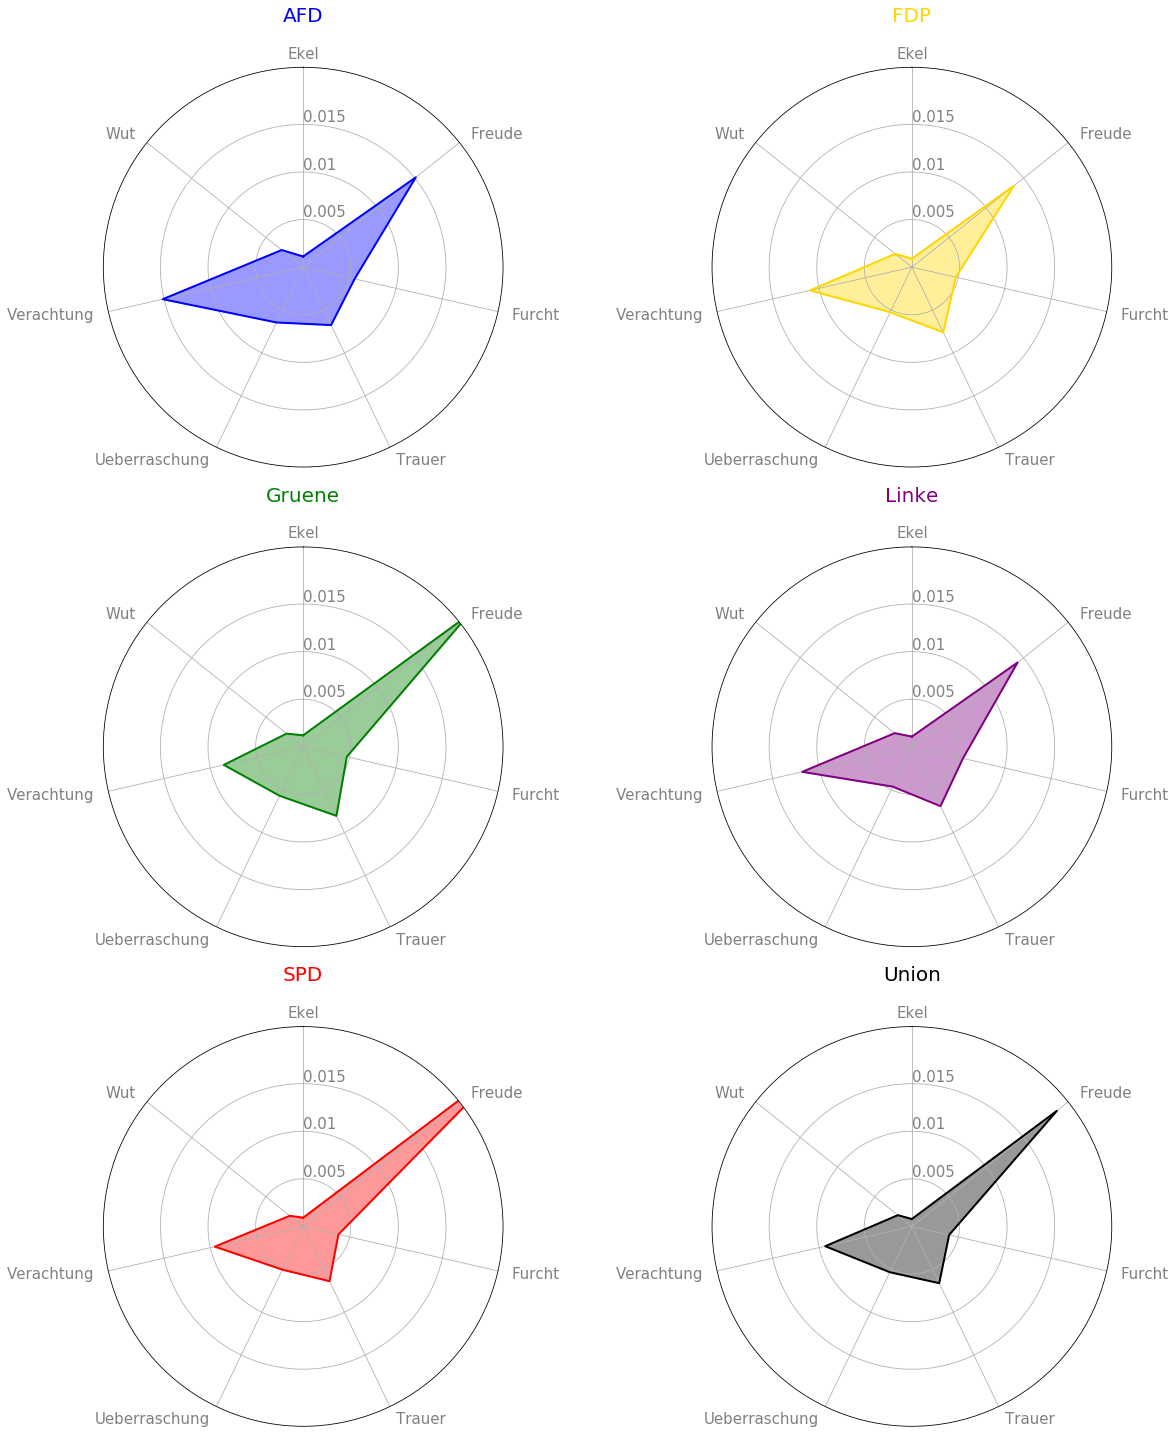

In [572]:
#https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):
    # number of variable
    categories=list(df)[0:]
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(3,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet #https://www.pythoncharts.com/2019/04/16/radar-charts/
    plt.xticks(angles[:-1], categories, color='grey', size=15)
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.005,0.01,0.015], ['0.005','0.01','0.015'], color="grey", size=15)
    plt.ylim(0,0.021)

    # Ind1
    values=df.loc[df1.index[row]].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=20, color=color, y=1.1)
 

# ------- PART 2: Apply to all individuals
# initialize the figure

df=emo_party_rel_1[emo_party_rel_1.columns[0:7]]

plt.figure(figsize=(20, 25))
fig.tight_layout()
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
my_palette = ['blue', 'gold', 'green', 'purple', 'red', 'black']
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title=df.index[row], color=my_palette[row])

In [554]:
values=df.loc[df1.index[row]].values.flatten().tolist()
values += values[:1]
values

[0.0007843216757157492,
 0.01948437552654482,
 0.004012597534079127,
 0.0066212777985288655,
 0.005339395599721563,
 0.009341837823767442,
 0.0018979473236260228]

In [555]:
df.loc[df1.index[row]]

Ekel             0.000784
Freude           0.019484
Furcht           0.004013
Trauer           0.006621
Ueberraschung    0.005339
Verachtung       0.009342
Wut              0.001898
Name: Union, dtype: float64

6
6
6
6
6
6
6
6


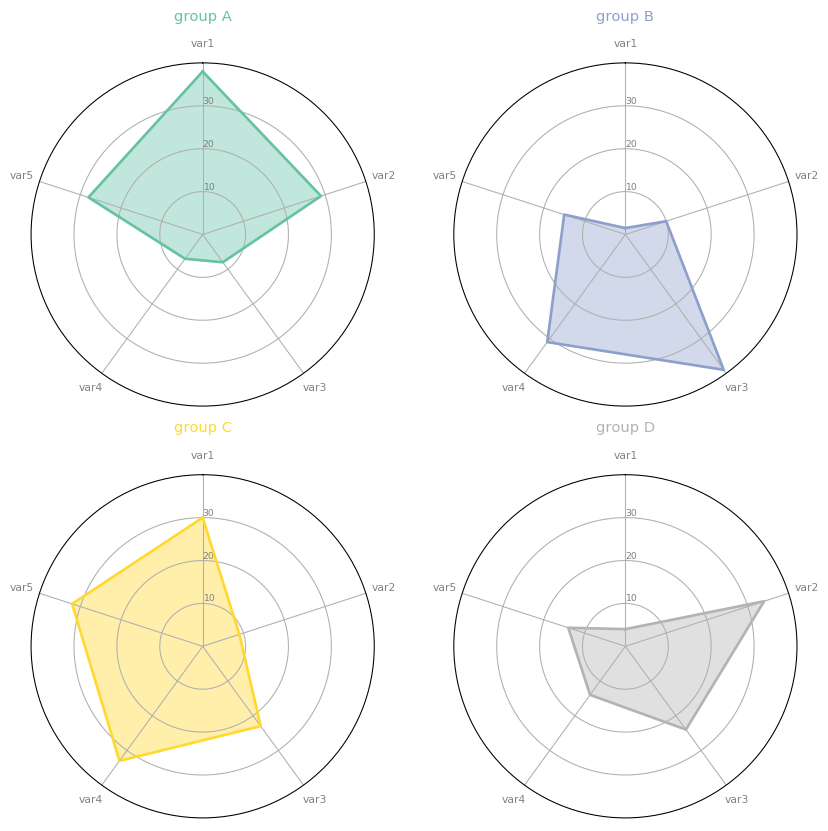

In [503]:
#https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'], # entspricht Partei
'var1': [38, 1.5, 30, 4], # entspricht Emotion
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
 
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,40)

    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    print(len(values))
    print(len(angles))
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)
 

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='group '+df['group'][row], color=my_palette(row))
